# Quickstart

[Try the image search live in Relevance AI Dashboard](https://cloud.relevance.ai/demo/search/image-to-text).



<div>
<img src="https://github.com/RelevanceAI/RelevanceAI-readme-docs/blob/main/docs/GETTING_STARTED/example-applications/_assets/RelevanceAI_text_to_image.gif?raw=true" 
     alt="RelevanceAI Text to Image"
     style="width: 100% vertical-align: middle"/> 
<figcaption>
</div>



In this notebook we will show you how to create and experiment with a powerful text to image search engine using OpenAI's CLIP and Relevance AI.

# What I Need

- Project & API Key (The SDK will link you to the corresponding page or you can grab your API key from https://cloud.relevance.ai/ in the settings area)
- Python 3
- Relevance AI Installed as shown below. For more information visit [Installation guide](https://docs.relevance.ai/docs)

## Installation Requirements

In [ ]:
# Relevance AI installation
!pip install -U RelevanceAI[notebook]==0.27.0

# Clip installation
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

## Client Setup



In [ ]:
# If True, you will get a shorter form!
RUN_QUICK = True

In [ ]:
from relevanceai import Client 

"""
Running this cell will provide you with 
the link to sign up/login page where you can find your credentials.
Once you have signed up, click on the value under `Authorization token` 
in the API tab
and paste it in the appreared Auth token box below
"""

client = Client()

Authorization token (you can find it here: https://cloud.relevance.ai/sdk/api )
Auth token:··········


# Text-to-image search

To enable text-to-image search we will be using Relevance AI as the vector database and OpenAI's CLIP as the vectorizer, to vectorize text and images into CLIP vector embeddings.



## 1) Data
For this quickstart we will be using a sample e-commerce dataset. Alternatively, you can use your own dataset for the different steps.


In [ ]:
from relevanceai.datasets import get_ecommerce_2_dataset

docs = get_ecommerce_2_dataset()
{k:v for k, v in docs[0].items() if '_vector_' not in k}

## 2) Encode - Vectorize with CLIP
CLIP is a vectorizer from OpenAI that is trained to find similarities between text and image pairs. In the code below we set up CLIP. 

In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
import requests

# Clip image encoding function
def encode_image(image):
    # Download the image and preprocess it
    image = preprocess(Image.open(requests.get(image, stream=True).raw)).unsqueeze(0).to(device)
    # Feed the processed image through the CLIP neural net to get the corresponding vector
    with torch.no_grad():
      image_features = model.encode_image(image)
    # Lastly we convert it to a list so that we can send it through the SDK
    return image_features.tolist()[0]

# Clip text encoding function
def encode_text(text):
    # Get the text and tokenize it
    text = clip.tokenize([text]).to(device)
    # Feed the tokenized text through the CLIP neural net to get the corresponding vector
    with torch.no_grad():
        text_features = model.encode_text(text)
    return text_features.tolist()[0]

We then encode the data we have into vectors, this will take a couple of mins

In [ ]:
if RUN_QUICK:
  docs = docs[:500]

In [ ]:
from tqdm.notebook import tqdm

def encode_image_document(d):
    d['clip_product_image_vector_'] = encode_image(d['product_image'])

encode_status = [encode_image_document(d) for d in tqdm(docs)]

## 3) Insert

Uploading our documents into the dataset `quickstart_clip`.

In case you are uploading your own dataset, keep in mind that each document should have a field called '_id'. Such an id can be easily allocated using the uuid package:

```
import uuid

for d in docs:
  d['_id'] = uuid.uuid4().__str__()    # Each document must have a field '_id'
```



In [ ]:
client.insert_documents("quickstart_clip", docs)

Once we have uploaded the data, we can see the dataset on the [dashboard](https://cloud.relevance.ai/dataset/quickstart_clip/dashboard/monitor/vectors). 

The dashboard provides users with a great overview and statistics of the dataset as shown below. 

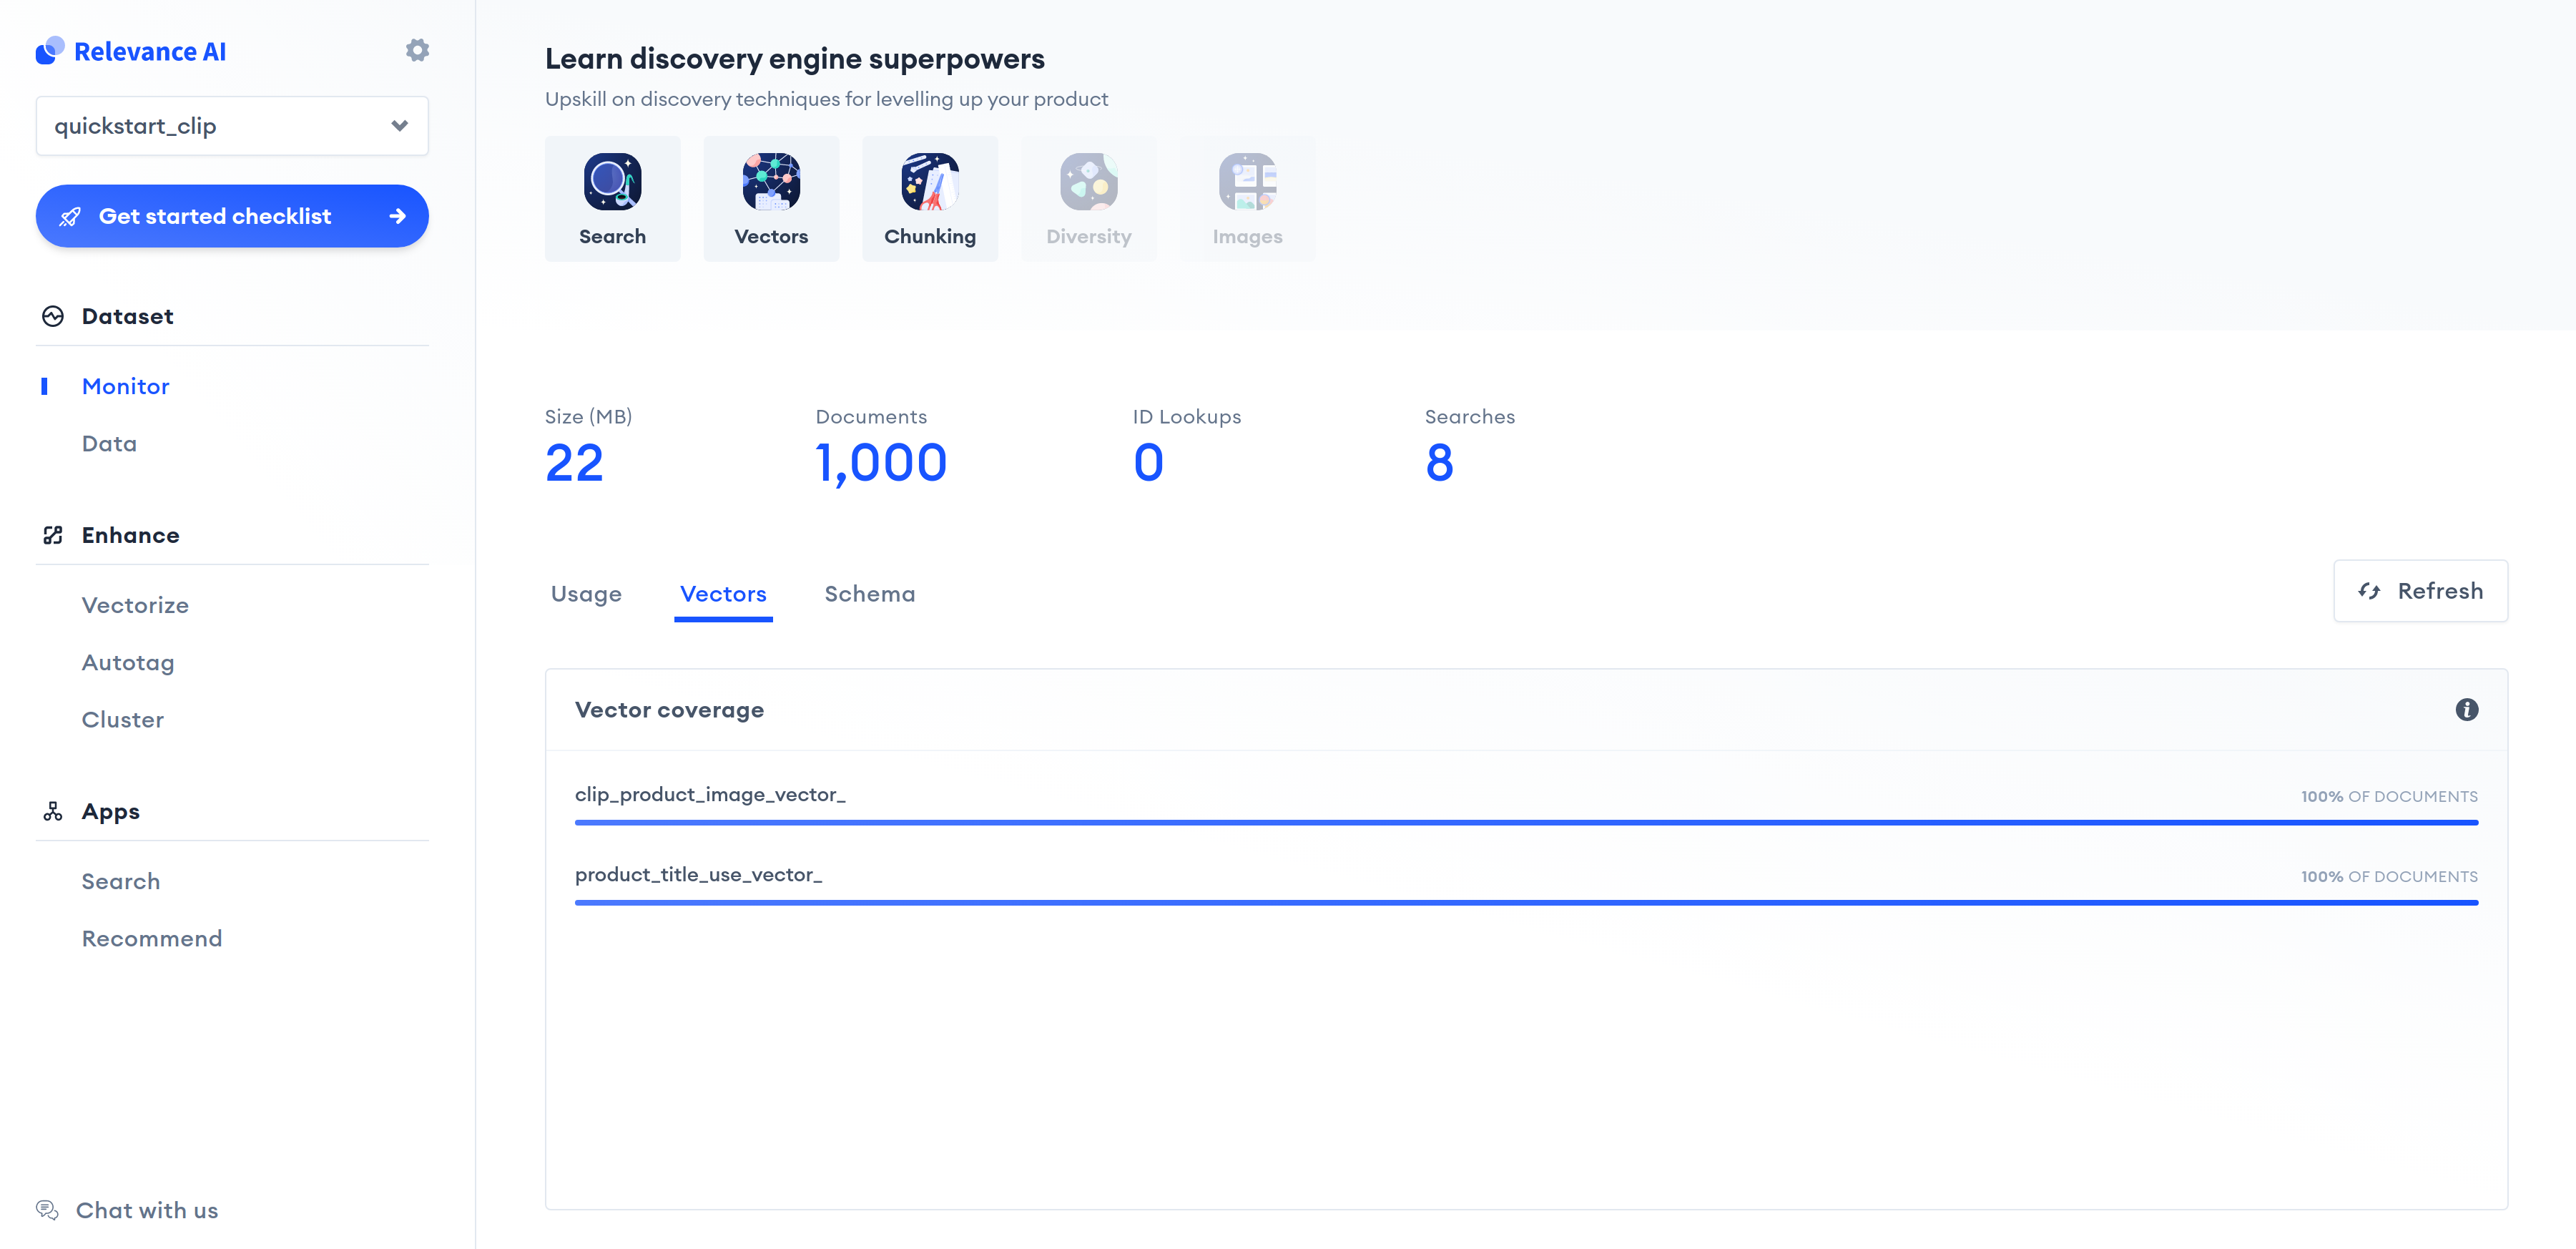

## 4) Search
This step is to run a simple vector search; you can read more about vector search and how to construct a multi-vector query [here](https://docs.relevance.ai/docs/hybrid-search). 

Note that our dataset includes vectors generated by the Clip encoder. Therefore, in this step, we first vectorize the query using the same encoder to be able to search among the similarly generated vectors.

In [ ]:
query = "for my baby daughter"
query_vector = encode_text(query) # vectorizing query

results = client.services.search.vector(
    dataset_id="quickstart_clip",
    multivector_query=[
        {
            "vector": query_vector,
            "fields": ["clip_product_image_vector_"]
        }
    ],
    page_size=5,
    query=query
)

You can use our json shower library to observe the search result in a notebook as shown below:

In [ ]:
from relevanceai import show_json

print('=== QUERY ===>  ', query)
show_json(
    results['results'],
    image_fields=["product_image"],
    text_fields=["product_title"]
)

# Projector 

Using Relevance AI projector, datapoints included in a datasets are projected into a 3D space

In [ ]:
client.projector.plot(
    dataset_id="quickstart_clip",
    number_of_points_to_render=100,
    vector_label = "product_title",
    vector_field="clip_product_image_vector_"
)

Other Notebooks:

- [Multivector search with your own vectors](doc:search-with-your-own-vectors) 
- [Text search using USE (VectorHub)](doc:quickstart-text-search) 
- [Question answering using USE QA (Tensorflow Hub)](doc:quickstart-question-answering) 